In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.integrator import DelIntegrator as DI
from varitop.opti import Varitop as VP

In [3]:
from darli.model import Functional
from darli.backend import CasadiBackend

In [4]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import casadi as cs
import numpy as np

In [5]:
urdf_path = '../../assets/urdf/2link_robot.urdf'
darli_model = Functional(CasadiBackend(urdf_path=urdf_path))
t0, tf, steps = 0.0, 3.0, 1000
dt = (tf - t0) / steps

In [6]:
di = DI(
    nq=darli_model.nq,
    nu=darli_model.nu,
    lagrangian=darli_model.lagrangian,
)

In [7]:
di.add_force(cs.vcat([di.u[0], 0]))

In [8]:
ns = 100
dt = 0.01

In [9]:
vp = VP(integrator=di, nsteps=ns, dt=dt)

In [10]:
q_0 = np.array([0, 0])
q_n = np.array([np.pi, np.pi])

In [11]:
vp.subject_to(vp.q[:, 0] - vp.q[:, 1] == 0)
vp.subject_to(vp.q[:, -1] - vp.q[:, -2] == 0)

In [12]:
vp.set_initial_configuration(q_0)
vp.set_terminal_configuration(q_n)

In [13]:
u_max = np.inf
lb = -u_max * np.ones((di.nu, ns))
ub = u_max * np.ones((di.nu, ns))
vp.bounded(lb, vp.u, ub)

In [14]:
cost = 0
for i in range(ns):
    cost += vp.u[:, i].T @ vp.u[:, i]

vp.set_cost(cost)

In [15]:
try:
    sol = vp.solve()
    q_opt = sol.value(vp.q)
    u_opt = sol.value(vp.u)
    print('Problem solved')
except Exception as e:
    q_opt = vp.problem.debug.value(vp.q)
    u_opt = vp.problem.debug.value(vp.u)
    print('Unable to solve, using debug')
    print(e)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1299
Number of nonzeros in inequality constraint Jacobian.:      200
Number of nonzeros in Lagrangian Hessian.............:      903

Total number of variables............................:      402
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      206
Total number of inequality c

In [16]:
ts = np.linspace(0, tf, len(q_opt.T))

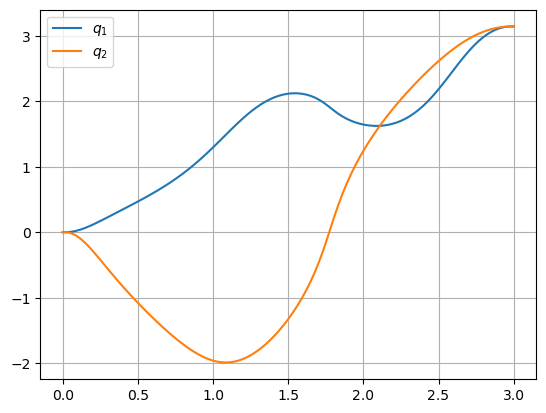

In [17]:
fig, ax = plt.subplots()

ax.plot(ts, q_opt.T, label=['$q_1$', '$q_2$'])
ax.legend()
ax.grid()
plt.show()

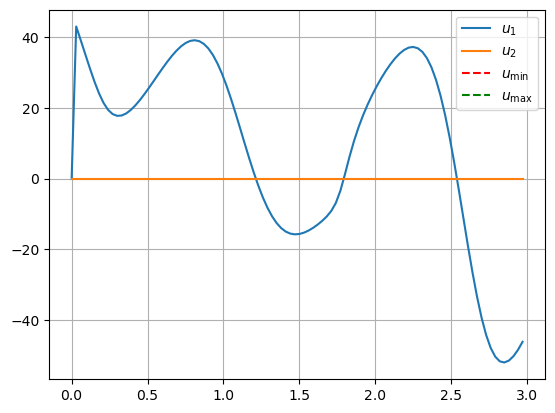

In [18]:
fig, ax = plt.subplots()
ax.plot(ts[:-1], u_opt.T, label=['$u_1$', '$u_2$'])
ax.hlines(-u_max, 0, tf, colors='r', linestyles='--', label='$u_{\\text{min}}$')
ax.hlines(u_max, 0, tf, colors='g', linestyles='--', label='$u_{\\text{max}}$')
ax.legend()
ax.grid()
plt.show()

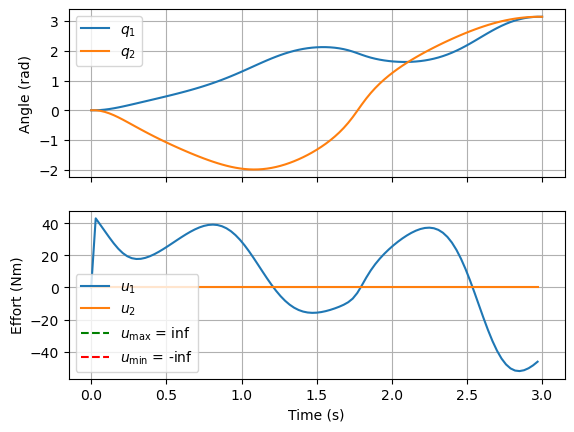

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(ts, q_opt.T, label=['$q_1$', '$q_2$'])
ax[1].plot(ts[:-1], u_opt.T, label=['$u_1$', '$u_2$'])
ax[1].hlines(u_max, 0, tf, colors='g', linestyles='--', label='$u_{\\text{max}}$' + f' = {u_max}')
ax[1].hlines(-u_max, 0, tf, colors='r', linestyles='--', label='$u_{\\text{min}}$' + f' = {-u_max}')
ax[0].legend()
ax[0].set_ylabel('Angle (rad)')
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[1].set_ylabel('Effort (Nm)')
ax[1].set_xlabel('Time (s)')
plt.savefig(f'bounds_{u_max}.png', dpi=300)

In [20]:
np.sum([u.T @ u for u in u_opt.T])

79609.18879899583

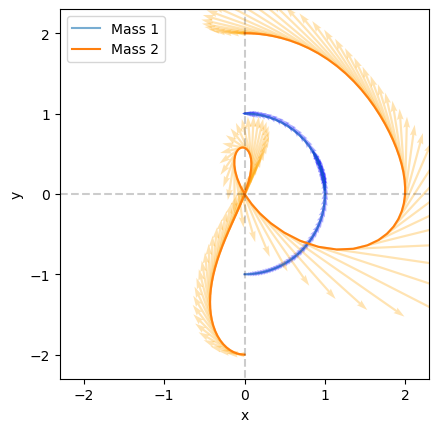

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

L1 = 1.0
L2 = 1.0
m1 = 1.0
m2 = 1.0
g = 9.8
dt = 0.01
t = np.arange(0, 10, dt)

# Convert angles to Cartesian coordinates
x1 = L1 * np.sin(q_opt[0, :])
y1 = -L1 * np.cos(q_opt[0, :])
x2 = x1 + L2 * np.sin(q_opt[1, :])
y2 = y1 - L2 * np.cos(q_opt[1, :])

# Calculate differences for direction
dx1 = np.diff(x1)
dy1 = np.diff(y1)
dx2 = np.diff(x2)
dy2 = np.diff(y2)


# Add a zero at the end of differences to make them the same size as x and y arrays
dx1 = np.concatenate((dx1, [0]))
dy1 = np.concatenate((dy1, [0]))
dx2 = np.concatenate((dx2, [0]))
dy2 = np.concatenate((dy2, [0]))

# Plot the trajectory with quivers
ax.plot(x1, y1, label='Mass 1', alpha=0.6)
ax.quiver(x1, y1, dx1, dy1, angles='xy', scale_units='xy', scale=0.3, color='blue', alpha=0.3)
ax.plot(x2, y2, label='Mass 2')
ax.quiver(x2, y2, dx2, dy2, angles='xy', scale_units='xy', scale=0.1, color='orange', alpha=0.3)

# plot vertical line
ax.plot([0, 0], [-3, 3], 'k--', alpha=0.2)
ax.hlines(0, -2.3, 2.3, 'k', alpha=0.2, linestyles='--')
ax.set_aspect('equal')
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig(f'trajectory_{u_max}.png', dpi=300)

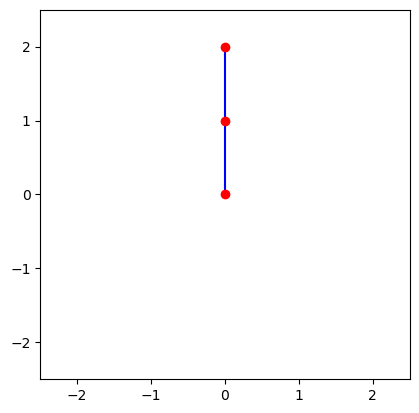

In [22]:
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()

# Set the x and y limits of the plot
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect("equal")

# Create a line object for the line between the points
(line1,) = ax.plot([], [], "b-")
(line2,) = ax.plot([], [], "b-")

# Create a scatter plot for the points
(points,) = ax.plot([], [], "ro")


# Animation update function
def update(frame):
    # Update the line and points data
    line1.set_data([0, x1[frame]], [0, y1[frame]])
    line2.set_data([x1[frame], x2[frame]], [y1[frame], y2[frame]])
    points.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
    
    return line1, line2, points


# Create the animation
animation = FuncAnimation(fig, update, frames=len(x1), blit=True)

# Show the plot
animation.save("test.gif", writer="pillow")